# Генетски алгоритми

Овај нотебук је део [AI for Beginners Curriculum](http://github.com/microsoft/ai-for-beginners).


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## Нека теорија

**Генетски алгоритми** (GA) засновани су на **еволутивном приступу** вештачкој интелигенцији, где се методе еволуције популације користе за добијање оптималног решења за дати проблем. Предложио их је 1975. године [Џон Хенри Холанд](https://en.wikipedia.org/wiki/John_Henry_Holland).

Генетски алгоритми засновани су на следећим идејама:
* Валидна решења проблема могу се представити као **гени**
* **Укрштање** нам омогућава да комбинујемо два решења како бисмо добили ново валидно решење
* **Селекција** се користи за избор оптималнијих решења помоћу неке **функције прилагођености**
* **Мутације** се уводе ради дестабилизације оптимизације и изласка из локалног минимума

Ако желите да имплементирате генетски алгоритам, потребно је следеће:

* Пронаћи метод за кодирање решења проблема помоћу **гена** $g\in\Gamma$
* На скупу гена $\Gamma$ потребно је дефинисати **функцију прилагођености** $\mathrm{fit}: \Gamma\to\mathbb{R}$. Мање вредности функције одговарају бољим решењима.
* Дефинисати механизам **укрштања** за комбиновање два гена како би се добило ново валидно решење $\mathrm{crossover}: \Gamma^2\to\Gamma$.
* Дефинисати механизам **мутације** $\mathrm{mutate}: \Gamma\to\Gamma$.
У многим случајевима, алгоритми за укрштање и мутацију су прилично једноставни за манипулацију генима као нумеричким низовима или бит-векторима.

Специфична имплементација генетског алгоритма може се разликовати од случаја до случаја, али општа структура је следећа:

1. Изабрати почетну популацију $G\subset\Gamma$
2. Насумично изабрати једну од операција која ће се извршити у овом кораку: укрштање или мутација
3. **Укрштање**:
   * Насумично изабрати два гена $g_1, g_2 \in G$
   * Израчунати укрштање $g=\mathrm{crossover}(g_1,g_2)$
   * Ако је $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ или $\mathrm{fit}(g)<\mathrm{fit}(g_2)$ - заменити одговарајући ген у популацији са $g$.
4. **Мутација** - изабрати насумичан ген $g\in G$ и заменити га са $\mathrm{mutate}(g)$
5. Поновити од корака 2, док не добијемо довољно малу вредност $\mathrm{fit}$, или док се не достигне ограничење на број корака.

Задаци који се обично решавају помоћу генетских алгоритама:
1. Оптимизација распореда
1. Оптимално паковање
1. Оптимално сечење
1. Убрзавање исцрпне претраге


## Проблем 1: Праведна подела блага

**Задатак**:  
Двоје људи су пронашли благо које садржи дијаманте различитих величина (и, сходно томе, различите цене). Потребно је да поделе благо на два дела тако да разлика у цени буде 0 (или минимална).

**Формална дефиниција**:  
Имамо скуп бројева $S$. Потребно је да га поделимо на два подскупа $S_1$ и $S_2$, тако да $$\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$$ и $S_1\cup S_2=S$, $S_1\cap S_2=\emptyset$.

Прво, хајде да дефинишемо скуп $S$:


In [3]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[8344 2197 9335 3131 5863 9429 3818 9791   15 5455 1396 9538 4872 6549
 8587 5986 6021 9764 8102 5083 5739 7684 8498 3007 6599  820 7490 2372
 9370 5235 3525 3154  859 1906 8159 3950 2173 2988 2050  349 8713 2284
 4177 6033 1651 9176 5049 8201  171 5081 1216 3756 4711 2757 7738 1272
 5650 6584 5395 9004 7797  969 8104 1283 1392 4001 5768  445  274  256
 8239 8015 4381 9021 1189 8879 1411 3539 6526 8011  136 7230 2332  451
 5702 2989 4320 2446 9578 8486 4027 2410 9588 8981 2177 1493 3232 9151
 4835 5594 6859 8394  369 3200  126 4259 2283 7755 2014 2458 8327 8082
 7413 7622 1206 5533 8751 3495 5868 8472 6850 3958 3149 4672 4810 6274
 4700 6134 4627 4616 6656 9949  884 2256 7419 1926 7973 5319 5967 9158
 3823 7697 9466 5675 5412 9784 5426 8209 3421 1136 6047 4429 8001 4417
 1381  722 7350 6018 6235 7860 5853 7660 5937 6242    1 9552 3971 8302
 2633 9227 7283  154 8599 4269 9392 8539 1630  368 2409 9351 3838 9814
 6186 5743 5083 1325 1610  779 3643 3262 5768 8725  961 4611 6310 4788
 1648 

Хајде да кодирамо свако могуће решење проблема бинарним вектором $B\in\{0,1\}^N$, где број на $i$-тој позицији показује којем од скупова ($S_1$ или $S_2$) $i$-ти број у оригиналном скупу $S$ припада. Функција `generate` ће генерисати те случајне бинарне векторе.


In [5]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0]


Хајде сада да дефинишемо функцију `fit` која израчунава "трошак" решења. То ће бити разлика између збира два скупа, $S_1$ и $S_2$:


In [6]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

133784

Сада треба да дефинишемо функције за мутацију и укрштање:  
* За мутацију, изабраћемо један случајни бит и променити га у супротну вредност (променити из 0 у 1 и обрнуто).  
* За укрштање, узећемо неке битове из једног вектора, а неке из другог. Користићемо исту функцију `generate` да насумично одредимо које битове ћемо узети из којих улазних маски.  


In [7]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

Хајде да креирамо почетну популацију решења $P$ величине `pop_size`:


In [8]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

Сада, главна функција за извођење еволуције. `n` представља број корака еволуције који треба да се изврше. У сваком кораку:
* Са вероватноћом од 30% извршавамо мутацију и замењујемо елемент са најгором функцијом `fit` мутираним елементом
* Са вероватноћом од 70% извршавамо укрштање

Функција враћа најбоље решење (ген који одговара најбољем решењу) и историју минималне функције `fit` у популацији на свакој итерацији.


In [9]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0
 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1] 4


Можете видети да смо успели да минимизирамо функцију `fit` прилично! Ево графикона који показује како се функција `fit` за целокупну популацију понаша током процеса.


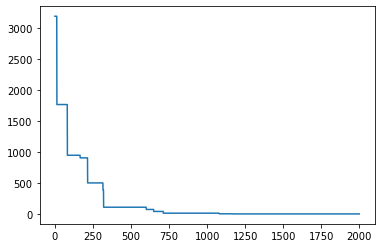

In [10]:
plt.plot(hist)
plt.show()

## Проблем 2: Проблем N дама

**Задатак**:  
Потребно је поставити $N$ дама на шаховску таблу величине $N\times N$ тако да се међусобно не нападају.

Прво ћемо решити проблем без коришћења генетских алгоритама, користећи потпуну претрагу. Стање табле можемо представити листом $L$, где је $i$-ти број у листи хоризонтална позиција даме у $i$-том реду. Сасвим је очигледно да ће свако решење имати само једну даму по реду, и сваки ред ће имати једну даму.

Наш циљ ће бити да пронађемо прво решење проблема, након чега ћемо зауставити претрагу. Ову функцију лако можете проширити како бисте генерисали све могуће позиције за даме.


In [11]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False
            
nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

Сада да измеримо колико времена је потребно да се добије решење за проблем са 20 краљица:


In [12]:
%timeit nqueens([],20,False)

10.6 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Сада ћемо решити исти проблем користећи генетски алгоритам. Ово решење је инспирисано [овим блог постом](https://kushalvyas.github.io/gen_8Q.html).

Свако решење ћемо представити истом листом дужине $N$, а као `fit` функцију узимамо број краљица које нападају једна другу:


In [13]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

Пошто је израчунавање функције прилагођености временски захтевно, хајде да сачувамо свако решење у популацији заједно са вредношћу функције прилагођености. Хајде да генеришемо почетну популацију:


In [14]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([2, 3, 8, 7, 5, 4, 1, 6]), 4),
 (array([3, 4, 5, 1, 2, 8, 6, 7]), 8),
 (array([1, 3, 7, 4, 5, 8, 6, 2]), 6),
 (array([1, 5, 4, 6, 8, 3, 7, 2]), 4),
 (array([3, 5, 7, 1, 8, 6, 4, 2]), 3)]

Сада треба да дефинишемо функције мутације и укрштања. Укрштање би комбиновало два гена заједно тако што би их прекинуло на некој насумичној тачки и спојило два дела из различитих гена заједно.


In [15]:
def mutate(G):
    x=random.randint(0,len(G)-1)
    G[x]=random.randint(1,len(G))
    return G
    
def xover(G1,G2):
    x=random.randint(0,len(G1))
    return np.concatenate((G1[:x],G2[x:]))

xover([1,2,3,4],[5,6,7,8])

array([1, 2, 7, 8])

In [17]:
def choose_rand(P):
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

Сада ћемо дефинисати главну еволуциону петљу. Логику ћемо учинити мало другачијом у односу на претходни пример, како бисмо показали да можете бити креативни. Петља ће се понављати док не добијемо савршено решење (функција прилагођености = 0), а у сваком кораку ћемо узети тренутну генерацију и произвести нову генерацију исте величине. Ово се постиже коришћењем функције `nxgeneration`, пратећи следеће кораке:

1. Одбаците најмање прилагођена решења - постоји функција `discard_unfit` која то ради
1. Додајте још неколико насумичних решења у генерацију
1. Попуните нову генерацију величине `gen_size` пратећи следеће кораке за сваки нови ген:
    - изаберите два насумична гена, са вероватноћом пропорционалном функцији прилагођености
    - израчунајте укрштање
    - примените мутацију са вероватноћом `mutation_prob`


In [20]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n=mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
        '''
        if (nf<=P[p1][1]) or (nf<=P[p2][1]):
            new_gen.append((n,nf))
        elif (P[p1][1]<P[p2][1]):
            new_gen.append(P[p1])
        else:
            new_gen.append(P[p2])
        '''
    return new_gen
    
def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        #print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

(array([4, 7, 5, 3, 1, 6, 8, 2]), 0)

Интересантно је да у већини случајева можемо брзо доћи до решења, али у неким ретким случајевима оптимизација достиже локални минимум, и процес је дуго заглављен. Важно је узети то у обзир када мерите просечно време: док ће у већини случајева генетски алгоритам бити бржи од потпуне претраге, у неким случајевима може трајати дуже. Да би се превазишао овај проблем, често има смисла ограничити број генерација које се разматрају, и ако не можемо пронаћи решење - можемо почети из почетка.


In [19]:
%timeit genetic(10)

The slowest run took 18.71 times longer than the fastest. This could mean that an intermediate result is being cached.
26.4 s ± 28.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



---

**Одрицање од одговорности**:  
Овај документ је преведен коришћењем услуге за превођење помоћу вештачке интелигенције [Co-op Translator](https://github.com/Azure/co-op-translator). Иако се трудимо да обезбедимо тачност, молимо вас да имате у виду да аутоматизовани преводи могу садржати грешке или нетачности. Оригинални документ на његовом изворном језику треба сматрати меродавним извором. За критичне информације препоручује се професионални превод од стране људи. Не преузимамо одговорност за било каква погрешна тумачења или неспоразуме који могу настати услед коришћења овог превода.
